In [166]:
import argparse
from time import time
import math

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder, CIFAR100
from torchsummary import summary


!pip install opendatasets
import opendatasets as od

od.download('https://www.kaggle.com/c/2021-ai-training-final-project/data')
data_dir = './2021-ai-training-final-project/CIFAR100'

Skipping, found downloaded files in "./2021-ai-training-final-project" (use force=True to force download)


In [167]:
!pip install torchtoolbox

In [168]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

device = get_default_device()
print(device)
!nvidia-smi

cpu
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [169]:

# Data args
dataset='cifar100'
workers=4
print_freq=10
checkpoint_path='cct6-3x2_cifar100_best.pth'

# Optimization hyperparams
epochs=1
warmup=5
batch_size=128
lr=0.0005
weight_decay=3e-2
clip_grad_norm=0.
model='cct_6'
positional_embedding='learnable'
conv_layers=2
conv_size=3
patch_size=4
gpu_id=0
no_cuda=False


def accuracy(output, target):
    with torch.no_grad():
        batch_size = target.size(0)

        _, pred = output.topk(1, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        correct_k = correct[:1].flatten().float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
        return res


def cls_validate(val_loader, model, history, time_begin=None):
    model.eval()
    acc1_val = 0
    n = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(val_loader):
            if (not no_cuda) and torch.cuda.is_available():
                images = images.cuda(gpu_id, non_blocking=True)
                target = target.cuda(gpu_id, non_blocking=True)

            output = model(images)

            acc1 = accuracy(output, target)
            n += images.size(0)
            acc1_val += float(acc1[0] * images.size(0))

            if print_freq >= 0 and i % print_freq == 0:
                avg_acc1 = (acc1_val / n)
                print(f'[Eval][{i}] \t Top-1 {avg_acc1:6.2f}')
                history.append(avg_acc1)

    avg_acc1 = (acc1_val / n)
    total_mins = -1 if time_begin is None else (time() - time_begin) / 60
    print(f'[Final]\t \t Top-1 {avg_acc1:6.2f} \t \t Time: {total_mins:.2f}')

    return avg_acc1, history

In [170]:
#src/cct.py 
import torch.nn as nn


class CCT(nn.Module):
    def __init__(self,
                 img_size=224,
                 embedding_dim=768,
                 n_input_channels=3,
                 n_conv_layers=1,
                 kernel_size=7,
                 stride=2,
                 padding=3,
                 pooling_kernel_size=3,
                 pooling_stride=2,
                 pooling_padding=1,
                 *args, **kwargs):
        super(CCT, self).__init__()

        self.tokenizer = Tokenizer(n_input_channels=n_input_channels,
                                   n_output_channels=embedding_dim,
                                   kernel_size=kernel_size,
                                   stride=stride,
                                   padding=padding,
                                   pooling_kernel_size=pooling_kernel_size,
                                   pooling_stride=pooling_stride,
                                   pooling_padding=pooling_padding,
                                   max_pool=True,
                                   activation=nn.ReLU,
                                   n_conv_layers=n_conv_layers,
                                   conv_bias=False)

        self.classifier = TransformerClassifier(
            sequence_length=self.tokenizer.sequence_length(n_channels=n_input_channels,
                                                           height=img_size,
                                                           width=img_size),
            embedding_dim=embedding_dim,
            seq_pool=True,
            dropout_rate=0.,
            attention_dropout=0.1,
            stochastic_depth=0.1,
            *args, **kwargs)

    def forward(self, x):
        x = self.tokenizer(x)
        return self.classifier(x)



def _cct(num_layers, num_heads, mlp_ratio, embedding_dim,
         kernel_size=3, stride=None, padding=None,
         *args, **kwargs):
    stride = stride if stride is not None else max(1, (kernel_size // 2) - 1)
    padding = padding if padding is not None else max(1, (kernel_size // 2))
    return CCT(num_layers=num_layers,
               num_heads=num_heads,
               mlp_ratio=mlp_ratio,
               embedding_dim=embedding_dim,
               kernel_size=kernel_size,
               stride=stride,
               padding=padding,
               *args, **kwargs)



def cct_6(*args, **kwargs):
    return _cct(num_layers=6, num_heads=4, mlp_ratio=2, embedding_dim=256,
                *args, **kwargs)





In [171]:
#/src/utils/tokenizer.py 
class Tokenizer(nn.Module):
    def __init__(self,
                 kernel_size, stride, padding,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 n_conv_layers=1,
                 n_input_channels=3,
                 n_output_channels=64,
                 in_planes=64,
                 activation=None,
                 max_pool=True,
                 conv_bias=False):
        super(Tokenizer, self).__init__()

        n_filter_list = [n_input_channels] + \
                        [in_planes for _ in range(n_conv_layers - 1)] + \
                        [n_output_channels]

        self.conv_layers = nn.Sequential(
            *[nn.Sequential(
                nn.Conv2d(n_filter_list[i], n_filter_list[i + 1],
                          kernel_size=(kernel_size, kernel_size),
                          stride=(stride, stride),
                          padding=(padding, padding), bias=conv_bias),
                nn.Identity() if activation is None else activation(),
                nn.MaxPool2d(kernel_size=pooling_kernel_size,
                             stride=pooling_stride,
                             padding=pooling_padding) if max_pool else nn.Identity()
            )
                for i in range(n_conv_layers)
            ])

        self.flattener = nn.Flatten(2, 3)
        self.apply(self.init_weight)

    def sequence_length(self, n_channels=3, height=224, width=224):
        return self.forward(torch.zeros((1, n_channels, height, width))).shape[1]

    def forward(self, x):
        return self.flattener(self.conv_layers(x)).transpose(-2, -1)

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)


class TextTokenizer(nn.Module):
    def __init__(self,
                 kernel_size, stride, padding,
                 pooling_kernel_size=3, pooling_stride=2, pooling_padding=1,
                 embedding_dim=300,
                 n_output_channels=128,
                 activation=None,
                 max_pool=True,
                 *args, **kwargs):
        super(TextTokenizer, self).__init__()

        self.max_pool = max_pool
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, n_output_channels,
                      kernel_size=(kernel_size, embedding_dim),
                      stride=(stride, 1),
                      padding=(padding, 0), bias=False),
            nn.Identity() if activation is None else activation(),
            nn.MaxPool2d(
                kernel_size=(pooling_kernel_size, 1),
                stride=(pooling_stride, 1),
                padding=(pooling_padding, 0)
            ) if max_pool else nn.Identity()
        )

        self.apply(self.init_weight)

    def seq_len(self, seq_len=32, embed_dim=300):
        return self.forward(torch.zeros((1, seq_len, embed_dim)))[0].shape[1]

    def forward_mask(self, mask):
        new_mask = mask.unsqueeze(1).float()
        cnn_weight = torch.ones(
            (1, 1, self.conv_layers[0].kernel_size[0]),
            device=mask.device,
            dtype=torch.float)
        new_mask = F.conv1d(
            new_mask, cnn_weight, None,
            self.conv_layers[0].stride[0], self.conv_layers[0].padding[0], 1, 1)
        if self.max_pool:
            new_mask = F.max_pool1d(
                new_mask, self.conv_layers[2].kernel_size[0],
                self.conv_layers[2].stride[0], self.conv_layers[2].padding[0], 1, False, False)
        new_mask = new_mask.squeeze(1)
        new_mask = (new_mask > 0)
        return new_mask

    def forward(self, x, mask=None):
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.transpose(1, 3).squeeze(1)
        x = x if mask is None else x * self.forward_mask(mask).unsqueeze(-1).float()
        return x, mask

    @staticmethod
    def init_weight(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight)

In [172]:
#src/utils/transformers.py 
import torch
from torch.nn import Module, ModuleList, Linear, Dropout, LayerNorm, Identity, Parameter, init
import torch.nn.functional as F


class Attention(Module):
    """
    Obtained from timm: github.com:rwightman/pytorch-image-models
    """

    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = head_dim ** -0.5

        self.qkv = Linear(dim, dim * 3, bias=False)
        self.attn_drop = Dropout(attention_dropout)
        self.proj = Linear(dim, dim)
        self.proj_drop = Dropout(projection_dropout)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MaskedAttention(Module):
    def __init__(self, dim, num_heads=8, attention_dropout=0.1, projection_dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // self.num_heads
        self.scale = head_dim ** -0.5

        self.qkv = Linear(dim, dim * 3, bias=False)
        self.attn_drop = Dropout(attention_dropout)
        self.proj = Linear(dim, dim)
        self.proj_drop = Dropout(projection_dropout)

    def forward(self, x, mask=None):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale

        if mask is not None:
            mask_value = -torch.finfo(attn.dtype).max
            assert mask.shape[-1] == attn.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            mask = mask.unsqueeze(1).repeat(1, self.num_heads, 1, 1)
            attn.masked_fill_(~mask, mask_value)

        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class TransformerEncoderLayer(Module):
    """
    Inspired by torch.nn.TransformerEncoderLayer and timm.
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 attention_dropout=0.1, drop_path_rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.pre_norm = LayerNorm(d_model)
        self.self_attn = Attention(dim=d_model, num_heads=nhead,
                                   attention_dropout=attention_dropout, projection_dropout=dropout)

        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout1 = Dropout(dropout)
        self.norm1 = LayerNorm(d_model)
        self.linear2 = Linear(dim_feedforward, d_model)
        self.dropout2 = Dropout(dropout)

        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else Identity()

        self.activation = F.gelu

    def forward(self, src: torch.Tensor, *args, **kwargs) -> torch.Tensor:
        src = src + self.drop_path(self.self_attn(self.pre_norm(src)))
        src = self.norm1(src)
        src2 = self.linear2(self.dropout1(self.activation(self.linear1(src))))
        src = src + self.drop_path(self.dropout2(src2))
        return src


class MaskedTransformerEncoderLayer(Module):
    """
    Inspired by torch.nn.TransformerEncoderLayer and timm.
    """

    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1,
                 attention_dropout=0.1, drop_path_rate=0.1):
        super(MaskedTransformerEncoderLayer, self).__init__()
        self.pre_norm = LayerNorm(d_model)
        self.self_attn = MaskedAttention(dim=d_model, num_heads=nhead,
                                         attention_dropout=attention_dropout, projection_dropout=dropout)

        self.linear1 = Linear(d_model, dim_feedforward)
        self.dropout1 = Dropout(dropout)
        self.norm1 = LayerNorm(d_model)
        self.linear2 = Linear(dim_feedforward, d_model)
        self.dropout2 = Dropout(dropout)

        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0 else Identity()

        self.activation = F.gelu

    def forward(self, src: torch.Tensor, mask=None, *args, **kwargs) -> torch.Tensor:
        src = src + self.drop_path(self.self_attn(self.pre_norm(src), mask))
        src = self.norm1(src)
        src2 = self.linear2(self.dropout1(self.activation(self.linear1(src))))
        src = src + self.drop_path(self.dropout2(src2))
        return src


class TransformerClassifier(Module):
    def __init__(self,
                 seq_pool=True,
                 embedding_dim=768,
                 num_layers=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 dropout_rate=0.1,
                 attention_dropout=0.1,
                 stochastic_depth_rate=0.1,
                 positional_embedding='sine',
                 sequence_length=None,
                 *args, **kwargs):
        super().__init__()
        positional_embedding = positional_embedding if \
            positional_embedding in ['sine', 'learnable', 'none'] else 'sine'
        dim_feedforward = int(embedding_dim * mlp_ratio)
        self.embedding_dim = embedding_dim
        self.sequence_length = sequence_length
        self.seq_pool = seq_pool

        assert sequence_length is not None or positional_embedding == 'none', \
            f"Positional embedding is set to {positional_embedding} and" \
            f" the sequence length was not specified."

        if not seq_pool:
            sequence_length += 1
            self.class_emb = Parameter(torch.zeros(1, 1, self.embedding_dim),
                                       requires_grad=True)
        else:
            self.attention_pool = Linear(self.embedding_dim, 1)

        if positional_embedding != 'none':
            if positional_embedding == 'learnable':
                self.positional_emb = Parameter(torch.zeros(1, sequence_length, embedding_dim),
                                                requires_grad=True)
                init.trunc_normal_(self.positional_emb, std=0.2)
            else:
                self.positional_emb = Parameter(self.sinusoidal_embedding(sequence_length, embedding_dim),
                                                requires_grad=False)
        else:
            self.positional_emb = None

        self.dropout = Dropout(p=dropout_rate)
        dpr = [x.item() for x in torch.linspace(0, stochastic_depth_rate, num_layers)]
        self.blocks = ModuleList([
            TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                    dim_feedforward=dim_feedforward, dropout=dropout_rate,
                                    attention_dropout=attention_dropout, drop_path_rate=dpr[i])
            for i in range(num_layers)])
        self.norm = LayerNorm(embedding_dim)

        self.fc = Linear(embedding_dim, num_classes)
        self.apply(self.init_weight)

    def forward(self, x):
        if self.positional_emb is None and x.size(1) < self.sequence_length:
            x = F.pad(x, (0, 0, 0, self.n_channels - x.size(1)), mode='constant', value=0)

        if not self.seq_pool:
            cls_token = self.class_emb.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_token, x), dim=1)

        if self.positional_emb is not None:
            x += self.positional_emb

        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        if self.seq_pool:
            x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        else:
            x = x[:, 0]

        x = self.fc(x)
        return x

    @staticmethod
    def init_weight(m):
        if isinstance(m, Linear):
            init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, Linear) and m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, LayerNorm):
            init.constant_(m.bias, 0)
            init.constant_(m.weight, 1.0)

    @staticmethod
    def sinusoidal_embedding(n_channels, dim):
        pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                                for p in range(n_channels)])
        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])
        return pe.unsqueeze(0)


class MaskedTransformerClassifier(Module):
    def __init__(self,
                 seq_pool=True,
                 embedding_dim=768,
                 num_layers=12,
                 num_heads=12,
                 mlp_ratio=4.0,
                 num_classes=1000,
                 dropout_rate=0.1,
                 attention_dropout=0.1,
                 stochastic_depth_rate=0.1,
                 positional_embedding='sine',
                 seq_len=None,
                 *args, **kwargs):
        super().__init__()
        positional_embedding = positional_embedding if \
            positional_embedding in ['sine', 'learnable', 'none'] else 'sine'
        dim_feedforward = int(embedding_dim * mlp_ratio)
        self.embedding_dim = embedding_dim
        self.seq_len = seq_len
        self.seq_pool = seq_pool

        assert seq_len is not None or positional_embedding == 'none', \
            f"Positional embedding is set to {positional_embedding} and" \
            f" the sequence length was not specified."

        if not seq_pool:
            seq_len += 1
            self.class_emb = Parameter(torch.zeros(1, 1, self.embedding_dim),
                                       requires_grad=True)
        else:
            self.attention_pool = Linear(self.embedding_dim, 1)

        if positional_embedding != 'none':
            if positional_embedding == 'learnable':
                seq_len += 1  # padding idx
                self.positional_emb = Parameter(torch.zeros(1, seq_len, embedding_dim),
                                                requires_grad=True)
                init.trunc_normal_(self.positional_emb, std=0.2)
            else:
                self.positional_emb = Parameter(self.sinusoidal_embedding(seq_len,
                                                                          embedding_dim,
                                                                          padding_idx=True),
                                                requires_grad=False)
        else:
            self.positional_emb = None

        self.dropout = Dropout(p=dropout_rate)
        dpr = [x.item() for x in torch.linspace(0, stochastic_depth_rate, num_layers)]
        self.blocks = ModuleList([
            MaskedTransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads,
                                          dim_feedforward=dim_feedforward, dropout=dropout_rate,
                                          attention_dropout=attention_dropout, drop_path_rate=dpr[i])
            for i in range(num_layers)])
        self.norm = LayerNorm(embedding_dim)

        self.fc = Linear(embedding_dim, num_classes)
        self.apply(self.init_weight)

    def forward(self, x, mask=None):
        if self.positional_emb is None and x.size(1) < self.seq_len:
            x = F.pad(x, (0, 0, 0, self.n_channels - x.size(1)), mode='constant', value=0)

        if not self.seq_pool:
            cls_token = self.class_emb.expand(x.shape[0], -1, -1)
            x = torch.cat((cls_token, x), dim=1)
            if mask is not None:
                mask = torch.cat([torch.ones(size=(mask.shape[0], 1), device=mask.device), mask.float()], dim=1)
                mask = (mask > 0)

        if self.positional_emb is not None:
            x += self.positional_emb

        x = self.dropout(x)

        for blk in self.blocks:
            x = blk(x, mask=mask)
        x = self.norm(x)

        if self.seq_pool:
            x = torch.matmul(F.softmax(self.attention_pool(x), dim=1).transpose(-1, -2), x).squeeze(-2)
        else:
            x = x[:, 0]

        x = self.fc(x)
        return x

    @staticmethod
    def init_weight(m):
        if isinstance(m, Linear):
            init.trunc_normal_(m.weight, std=.02)
            if isinstance(m, Linear) and m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, LayerNorm):
            init.constant_(m.bias, 0)
            init.constant_(m.weight, 1.0)

    @staticmethod
    def sinusoidal_embedding(n_channels, dim, padding_idx=False):
        pe = torch.FloatTensor([[p / (10000 ** (2 * (i // 2) / dim)) for i in range(dim)]
                                for p in range(n_channels)])
        pe[:, 0::2] = torch.sin(pe[:, 0::2])
        pe[:, 1::2] = torch.cos(pe[:, 1::2])
        pe = pe.unsqueeze(0)
        if padding_idx:
            return torch.cat([torch.zeros((1, 1, dim)), pe], dim=1)
        return pe

In [173]:
#utils/stochastic_depth.py 
def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    This is the same as the DropConnect impl I created for EfficientNet, etc networks, however,
    the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for
    changing the layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use
    'survival rate' as the argument.
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    output = x.div(keep_prob) * random_tensor
    return output


class DropPath(nn.Module):
    """
    Obtained from: github.com:rwightman/pytorch-image-models
    Drop paths (Stochastic Depth) per sample  (when applied in main path of residual blocks).
    """

    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

In [174]:
def test(model, val_loader):
    with torch.no_grad():
        model.eval()
        valid_loss = 0
        correct = 0
        bs = batch_size
        result = []
        check_names = []
        for i, (data, target) in enumerate(val_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            arr = pred.data.cpu().numpy()
            for j in range(pred.size()[0]):
                file_name = val_dataset.samples[i*bs+j][0].split('/')[-1]
                result.append((file_name,pred[j].cpu().numpy()[0])) 
        
    with open ('ID_result.csv','w') as f:
        f.write('Id,Category\n')
        for data in result:
            f.write(data[0]+','+str(data[1])+'\n')

In [175]:
img_size = 32
num_classes = 100
img_mean, img_std = [0.5071, 0.4867, 0.4408], [0.2675, 0.2565, 0.2761]


model = cct_6(img_size=img_size,
              num_classes=num_classes,
              positional_embedding=positional_embedding,
              n_conv_layers=conv_layers,
              kernel_size=conv_size,
              patch_size=patch_size)

model.load_state_dict(torch.load(checkpoint_path, map_location='cpu'))
print("Loaded checkpoint.")

normalize = [transforms.Normalize(mean=img_mean, std=img_std)]

if (not no_cuda) and torch.cuda.is_available():
    torch.cuda.set_device(gpu_id)
    model.cuda(gpu_id)

val_dataset = ImageFolder(root=data_dir+"/TEST", 
            transform=transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor(),
            *normalize,
        ]))

val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=workers)

print("Beginning evaluation")
time_begin = time()
history = []

acc1, history = cls_validate(val_loader, model, history, time_begin=time_begin)

total_mins = (time() - time_begin) / 60
print(f'Script finished in {total_mins:.2f} minutes, '
      f'final top-1: {acc1:.2f}')
    


Loaded checkpoint.
Beginning evaluation


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[Eval][0] 	 Top-1  80.47
[Eval][10] 	 Top-1  73.08
[Eval][20] 	 Top-1  75.07
[Eval][30] 	 Top-1  74.92
[Eval][40] 	 Top-1  75.06
[Eval][50] 	 Top-1  74.86
[Eval][60] 	 Top-1  74.76
[Eval][70] 	 Top-1  74.72
[Final]	 	 Top-1  74.48 	 	 Time: 1.42
Script finished in 1.42 minutes, final top-1: 74.48


In [176]:
# Print model
print(model)

# Print parameter
size = summary(model, (3, 32, 32))

CCT(
  (tokenizer): Tokenizer(
    (conv_layers): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(64, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      )
    )
    (flattener): Flatten(start_dim=2, end_dim=3)
  )
  (classifier): TransformerClassifier(
    (attention_pool): Linear(in_features=256, out_features=1, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): TransformerEncoderLayer(
        (pre_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attn): Attention(
          (qkv): Linear(in_features=256, out_features=768, bias=False)
          (attn_drop): 

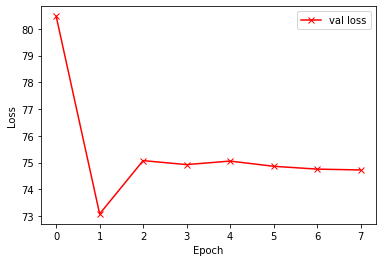

In [177]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

def plot_loss(history):
    plt.plot([x for x in history],"-rx")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["val loss"])


plot_loss(history)


In [178]:
result = test(model, val_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
